# Image Registration and Segmentation Using Deep Atlas Tutorial
CSIRO Vacation Studentship Preliminary Work

Hannah Tay Nov 2022

### DeepAtlas Method
1. Construct segmentation and registration models
2. Use the small number of segmentations (even just one!) to pre-train the segmentation model
3. Use the segmentation model as a source of weak supervision to help train the registration model
4. Use the registration model as a source of weak supervision to help train segmentation model
5. Repeat steps 3 and 4 in alternation, or carry out steps 3 and 4 simultaneously in one joint training loop

### Setup and Imports

In [1]:
# moved to requirements.txt

# !python3 -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
# !python3 -c "import matplotlib" || pip install -q matplotlib
# !python3 -c "import numpy" || pip install -q numpy
# !python3 -c "import torch" || pip install -q torch
# !python3 -c "import itk" || pip install -q itk

# %matplotlib inline

In [2]:
import monai
import torch
import itk
import numpy as np
import matplotlib.pyplot as plt
import random
import glob
import os.path
import tempfile

from utils import (
    preview_image, preview_3D_vector_field, preview_3D_deformation,
    jacobian_determinant, plot_against_epoch_numbers
)

monai.config.print_config()

# Set deterministic training for reproducibility
monai.utils.set_determinism(seed=2938649572)

/home/tay400/envs/mirorrnet/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 0.8.1
Numpy version: 1.19.5
Pytorch version: 1.10.2+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.2
scikit-image version: 0.17.2
Pillow version: 8.4.0
Tensorboard version: 2.6.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



### Download and Visualisation of Raw Data

In [3]:
# root_dir = tempfile.mkdtemp() 
# data_dir = os.path.join(tempfile.mkdtemp(), "OASIS-1")
data_dir = "../../src/data/OASIS-1"
# print(f"Root directory: {root_dir}")
# print(f"Data directory: {data_dir}")

# download and extract
resource = "https://download.nrg.wustl.edu/data/oasis_cross-sectional_disc1.tar.gz"
md5 = "c83e216ef8654a7cc9e2a30a4cdbe0cc"

compressed_file = "oasis_cross-sectional_disc1.tar.gz"
if not os.path.exists(data_dir):
    monai.apps.utils.download_and_extract(resource, compressed_file, data_dir, md5)

# build lists of data paths
num_segmentation_classes = 4  # background, CSF, white matter, gray matter

image_path_expression = "PROCESSED/MPRAGE/T88_111/OAS1_*_MR*_mpr_n*_anon_111_t88_masked_gfc.img"
segmentation_path_expression = "FSL_SEG/OAS1_*_MR*_mpr_n*_anon_111_t88_masked_gfc_fseg.img"

# Expect either of two reasonable ways of organizing extracted data:
# 1) /disc1/OAS1_0031_MR1/...
# 2) /OAS1_0031_MR1/...
image_paths = glob.glob(os.path.join(data_dir, '*', image_path_expression))
image_paths += glob.glob(os.path.join(data_dir, '*/*', image_path_expression))
segmentation_paths = glob.glob(os.path.join(data_dir, '*', segmentation_path_expression))
segmentation_paths += glob.glob(os.path.join(data_dir, '*/*', segmentation_path_expression))

# pretend that only a few segmentations are available
num_segs_to_select = 10
np.random.shuffle(segmentation_paths)
segmentation_paths = segmentation_paths[:num_segs_to_select]

# resize and device options
resize = 96
device = torch.device("cuda:1")

In [4]:
# Function to extract an image or segmentation ID from its path
def path_to_id(path):
    return os.path.basename(path).strip('OAS1_')[:8]


seg_ids = list(map(path_to_id, segmentation_paths))
img_ids = map(path_to_id, image_paths)
data = []
for img_index, img_id in enumerate(img_ids):
    data_item = {'img': image_paths[img_index]}
    if img_id in seg_ids:
        data_item['seg'] = segmentation_paths[seg_ids.index(img_id)]
    data.append(data_item)

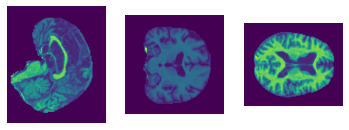

In [5]:
# preview a random image
data_item = random.choice(data)
preview_image(monai.transforms.LoadImage(image_only=True)(data_item['img']), figsize=(6,6), normalize_by="slice")

### Creating Datasets for Pre-Training of Segmentation Network

In [6]:
# select the subset of data that has segmentation labels available, then split into training and validation sets
data_seg_available = list(filter(lambda d: 'seg' in d.keys(), data))
data_seg_unavailable = list(filter(lambda d: 'seg' not in d.keys(), data))

data_seg_available_train, data_seg_available_valid = \
    monai.data.utils.partition_dataset(data_seg_available, ratios=(8, 2))
# Validation of the segmentation network only makes sense if you have enough segmentation labels.

In [7]:
# set up transforms that will be used to load images and segmentations for the pre=training
transform_seg_available = monai.transforms.Compose(
    # transforms=[
        monai.transforms.LoadImageD(keys=['img', 'seg'], ensure_channel_first=True, image_only=True),
        # monai.transforms.EnsureChannelFirstD(keys=['img', 'seg']),
        monai.transforms.TransposeD(keys=['img', 'seg'], indices=(2, 1, 0)),
        monai.transforms.ResizeD(
            keys=['img', 'seg'],
            spatial_size=(resize, resize, resize),
            mode=['trilinear', 'nearest'],
            align_corners=[False, None]
        ) if resize is not None else monai.transforms.Identity()
    # ]
)

# Supress the many warnings related to deprecation of the Analyze file format
# (without this, we would see warnings when the LoadImage transform calls itk to load Analyze files)
itk.ProcessObject.SetGlobalWarningDisplay(False)

# data = {'img': # set up transforms that will be used to load images and segmentations for the pre=training
transform_seg_available = monai.transforms.Compose(
    # transforms=[
        monai.transforms.LoadImageD(keys=['img', 'seg'], ensure_channel_first=True, image_only=True, reader="ITKReader"),
        # monai.transforms.EnsureChannelFirstD(keys=['img', 'seg']),
        monai.transforms.TransposeD(keys=['img', 'seg'], indices=(2, 1, 0)),
        monai.transforms.ResizeD(
            keys=['img', 'seg'],
            spatial_size=(resize, resize, resize),
            mode=['trilinear', 'nearest'],
            align_corners=[False, None]
        ) if resize is not None else monai.transforms.Identity()
    # ]
)

# Supress the many warnings related to deprecation of the Analyze file format
# (without this, we would see warnings when the LoadImage transform calls itk to load Analyze files)
itk.ProcessObject.SetGlobalWarningDisplay(False)

# data = {'img': 'OASIS-1/disc1/OAS1_0003_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0003_MR1_mpr_n4_anon_111_t88_masked_gfc.img', 'seg': 'OASIS-1/disc1/OAS1_0003_MR1/FSL_SEG/OAS1_0003_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg.img'}

# preview a random image with the transform above applied
data_item = transform_seg_available(random.choice(data_seg_available))
# data_item = transform_seg_available(data)
preview_image(data_item['img'][0])
preview_image(data_item['seg'][0])

RuntimeError: applying transform <monai.transforms.io.dictionary.LoadImaged object at 0x1554b1d3d668>

In [ ]:
# define pre-training datasets
dataset_seg_available_train = monai.data.CacheDataset(
    data=data_seg_available_train,
    transform=transform_seg_available,
    cache_num=16
)

dataset_seg_available_valid = monai.data.CacheDataset(
    data=data_seg_available_valid,
    transform=transform_seg_available,
    cache_num=16
)

Loading dataset: 100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


<h3>Creation of Datasets for Training Both Registration and Segmentation Networks</h3>
<p>Reserve some images for validation of registration network, then create data lists for <i>pairs</i> of images</p>

In [ ]:
# During the joint/alternating training process, we will use reuse data_seg_available_valid
# for validating the segmentation network.
# So we should not let the registration or segmentation networks see these images in training.
data_without_seg_valid = data_seg_unavailable + data_seg_available_train  # Note the order

# For validation of the registration network, we prefer not to use the precious data_seg_available_train,
# if that's possible. The following split tries to use data_seg_unavailable for the
# the validation set, to the extent possible.
data_valid, data_train = monai.data.utils.partition_dataset(
    data_without_seg_valid,  # Note the order
    ratios=(2, 8),  # Note the order
    shuffle=False
)


def take_data_pairs(data, symmetric=True):
    """Given a list of dicts that have keys for an image and maybe a segmentation,
    return a list of dicts corresponding to *pairs* of images and maybe segmentations.
    Pairs consisting of a repeated image are not included.
    If symmetric is set to True, then for each pair that is included, its reverse is also included"""
    data_pairs = []
    for i in range(len(data)):
        j_limit = len(data) if symmetric else i
        for j in range(j_limit):
            if j == i:
                continue
            d1 = data[i]
            d2 = data[j]
            pair = {
                'img1': d1['img'],
                'img2': d2['img']
            }
            if 'seg' in d1.keys():
                pair['seg1'] = d1['seg']
            if 'seg' in d2.keys():
                pair['seg2'] = d2['seg']
            data_pairs.append(pair)
    return data_pairs


data_pairs_valid = take_data_pairs(data_valid)
data_pairs_train = take_data_pairs(data_train)

In [ ]:
# subdivide the lists of data pairs based on the availability of seg1 and seg2 keys 
# key       segmentation availability
# ------------------------------------
# 00        no segs available
# 01        seg2 available, but no seg1
# 10        seg1 available, but no seg2
# 11        both segs available

def subdivide_list_of_data_pairs(data_pairs_list):
    out_dict = {'00': [], '01': [], '10': [], '11': []}
    for d in data_pairs_list:
        if 'seg1' in d.keys() and 'seg2' in d.keys():
            out_dict['11'].append(d)
        elif 'seg1' in d.keys():
            out_dict['10'].append(d)
        elif 'seg2' in d.keys():
            out_dict['01'].append(d)
        else:
            out_dict['00'].append(d)
    return out_dict


data_pairs_valid_subdivided = subdivide_list_of_data_pairs(data_pairs_valid)
data_pairs_train_subdivided = subdivide_list_of_data_pairs(data_pairs_train)

In [ ]:
# print some useful counts to be aware of

num_train_reg_net = len(data_pairs_train)
num_valid_reg_net = len(data_pairs_valid)
num_train_both = len(data_pairs_train_subdivided['01']) +\
    len(data_pairs_train_subdivided['10']) +\
    len(data_pairs_train_subdivided['11'])

print(f"Number of pairs to train reg_net and seg_net together: {num_train_both}")
print(f"Number of pairs to train reg_net alone: {num_train_reg_net - num_train_both}")
print(f"Number of pairs for reg_net validation: {num_valid_reg_net}")

Number of pairs to train reg_net and seg_net together: 408
Number of pairs to train reg_net alone: 462
Number of pairs for reg_net validation: 42


In [ ]:

# set up transforms used for loading image pairs
# fixed and moving images are concatenated along the channel dimension
transform_pair = monai.transforms.Compose(
    transforms=[
        monai.transforms.LoadImageD(keys=['img1', 'seg1', 'img2', 'seg2'], image_only=True, allow_missing_keys=True),
        monai.transforms.TransposeD(keys=['img1', 'seg1', 'img2', 'seg2'], indices=(2, 1, 0), allow_missing_keys=True),
        monai.transforms.EnsureChannelFirstD(keys=['img1', 'seg1', 'img2', 'seg2'], allow_missing_keys=True),
        monai.transforms.ConcatItemsD(keys=['img1', 'img2'], name='img12', dim=0),
        monai.transforms.DeleteItemsD(keys=['img1', 'img2']),
        monai.transforms.ResizeD(
            keys=['img12', 'seg1', 'seg2'],
            spatial_size=(resize, resize, resize),
            mode=['trilinear', 'nearest', 'nearest'],
            allow_missing_keys=True,
            align_corners=[False, None, None]
        ) if resize is not None else monai.transforms.Identity()
    ]
)

# TODO: introduce data augmentation


In [ ]:
# define datasets for training
# The following are dictionaries that map segmentation availability labels 00,10,01,11 to MONAI datasets

dataset_pairs_train_subdivided = {
    seg_availability: monai.data.CacheDataset(
        data=data_list,
        transform=transform_pair,
        cache_num=32
    )
    for seg_availability, data_list in data_pairs_train_subdivided.items()
}


dataset_pairs_valid_subdivided = {
    seg_availability: monai.data.CacheDataset(
        data=data_list,
        transform=transform_pair,
        cache_num=32
    )
    for seg_availability, data_list in data_pairs_valid_subdivided.items()
}

Loading dataset: 100%|██████████| 32/32 [00:07<00:00,  4.47it/s]


In [ ]:
# naming conventions:
#
# variable name component       suggested meaning
# ------------------------------------------------------------------------------------------------------------------------------
# data_                         data items are dictionaries with keys mapping to filepaths
# dataset_                      a MONAI dataset; getting an item loads images and applies transformations
# dataloader_                   a MONAI dataloader; items from datasets are collated into batches
# _train_                       data is meant for training
# _valid_                       data is meant for validation
# _seg_available_               ground truth segmentations are available
# _seg_unavailable_             ground truth segmentations are not available
# _pairs_                       data consists of ordered pairs of images and potentially segmentations
# _subdivided                   a mapping from segmentation availability labels (00. 01. 10. 11) to the suggested type of object

<h3>Creation of Segmentation Network</h3>
<p>Using a MONAI UNet</p>

In [ ]:
# segmentation network
seg_net = monai.networks.nets.UNet(
    3,  # spatial dims
    1,  # input channels
    num_segmentation_classes,  # output channels
    (8, 16, 16, 32, 32, 64, 64),  # channel sequence
    (1, 2, 1, 2, 1, 2),  # convolutional strides
    dropout=0.2,
    norm='batch'
)

In [ ]:
# Try out a forward pass
data_item = random.choice(dataset_seg_available_train)
seg_net_example_output = seg_net(data_item['img'].unsqueeze(0))
print(f"Segmentation classes: {torch.unique(data_item['seg']).as_tensor()}")
print(f"Shape of ground truth label: {data_item['seg'].unsqueeze(0).shape}")
print(f"Shape of seg_net output: {seg_net_example_output.shape}")

Segmentation classes: tensor([0., 1., 2., 3.])
Shape of ground truth label: torch.Size([1, 1, 176, 208, 176])
Shape of seg_net output: torch.Size([1, 4, 176, 208, 176])


In [ ]:
dice_loss = monai.losses.DiceLoss(
    include_background=True,
    to_onehot_y=True,  # Our seg labels are single channel images indicating class index, rather than one-hot
    softmax=True,  # Note that our segmentation network is missing the softmax at the end
    reduction="mean"
)

# A version of the dice loss with to_onehot_y=False and softmax=False;
# This will be handy for anatomy loss, for which we often compare two outputs of seg_net
dice_loss2 = monai.losses.DiceLoss(
    include_background=True,
    to_onehot_y=False,
    softmax=False,
    reduction="mean"
)

In [ ]:
# try out the two versions of dice loss on the example. The two values printed should be the same.

true_seg = data_item['seg'].unsqueeze(0)
print(
    dice_loss(
        seg_net_example_output, # Prediction from seg_net, as logits
        true_seg # Ground truth segmentation, as class labels rather than one-hot
    ),
    dice_loss2(
        seg_net_example_output.softmax(dim=1), # Prediction from seg_net, as probabilities
        monai.networks.one_hot(true_seg,
                               num_classes=num_segmentation_classes) # Ground truth segmentation, one-hot encoded
    ),
)


tensor(0.8608, grad_fn=<AliasBackward0>) tensor(0.8608, grad_fn=<AliasBackward0>)


<h3>Creation of Registration Network</h3>

In [ ]:
# Similar architecture to the one used in the paper
reg_net = monai.networks.nets.UNet(
    3,  # spatial dims
    2,  # input channels (one for fixed image and one for moving image)
    3,  # output channels (to represent 3D displacement vector field)
    (16, 32, 32, 32, 32),  # channel sequence
    (1, 2, 2, 2),  # convolutional strides
    dropout=0.2,
    norm="batch"
)

In [ ]:
# Try out a forward pass
def take_random_from_subdivided_dataset(dataset_subdivided):
    """Given a dict mapping segmentation availability labels to datasets, return a random data item"""
    datasets = list(dataset_subdivided.values())
    datasets_combined = sum(datasets[1:], datasets[0])
    return random.choice(datasets_combined)


data_item = take_random_from_subdivided_dataset(dataset_pairs_train_subdivided)
reg_net_example_input = data_item['img12'].unsqueeze(0)
reg_net_example_output = reg_net(reg_net_example_input)
print(f"Shape of reg_net input: {reg_net_example_input.shape}")
print(f"Shape of reg_net output: {reg_net_example_output.shape}")
image_scale = reg_net_example_input.shape[-1]  # comes in handy later

# the output of reg-net will be interpreted as a displacement vector field

Shape of reg_net input: torch.Size([1, 2, 96, 96, 96])
Shape of reg_net output: torch.Size([1, 3, 96, 96, 96])


<h5>Image Warping</h5>

monai.networks.blocks.Warp: Using PyTorch native grid_sample.


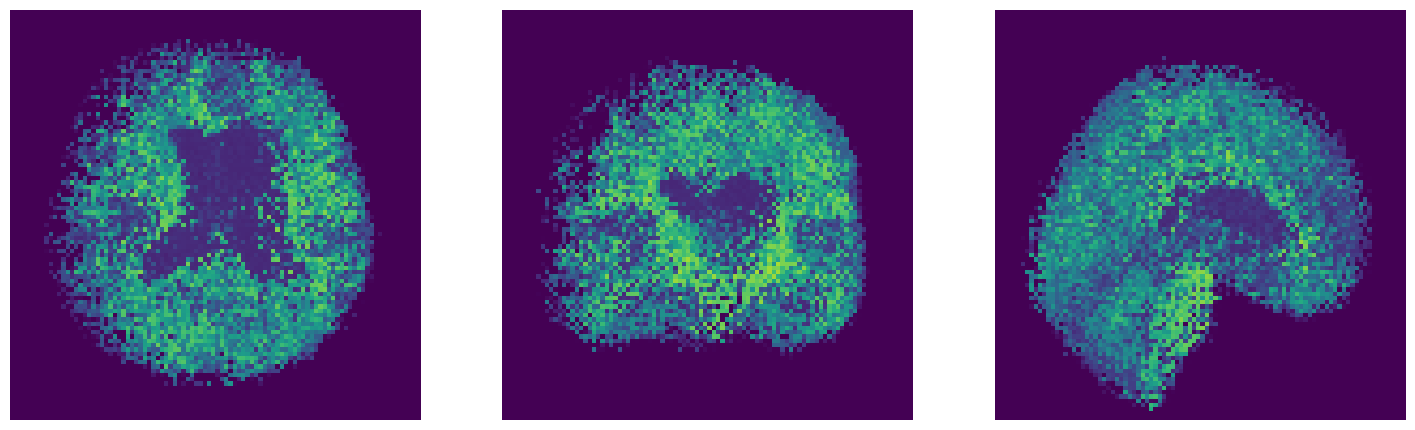

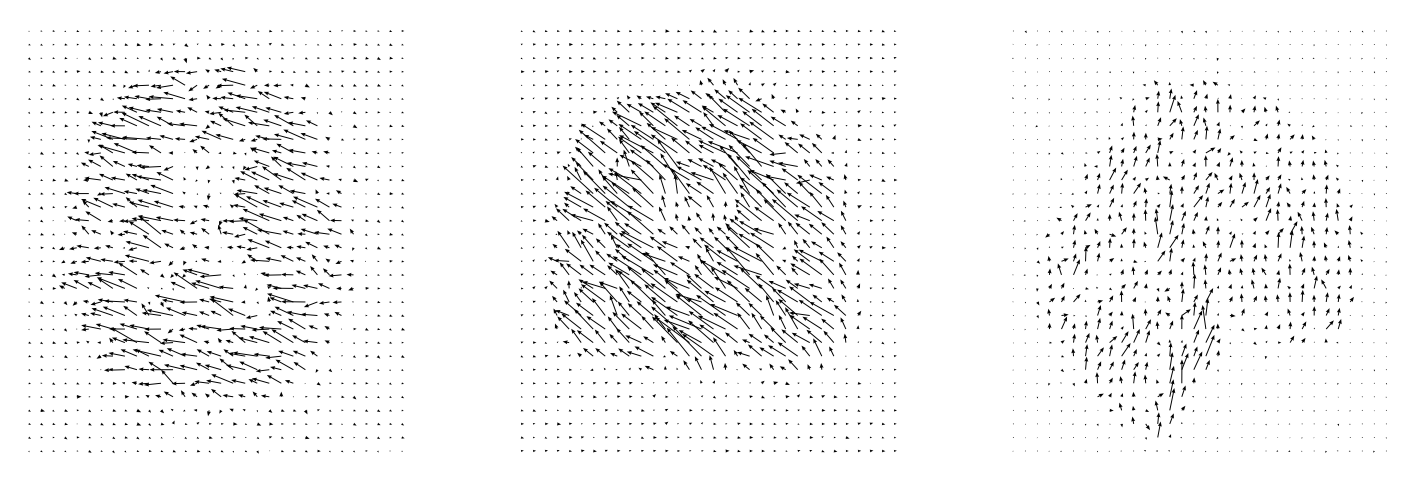

In [ ]:
# For warping segmentation labels or class predictions, we sometimes want to use nearest neighbor interpolation
# Note that "bilinear" means "trilinear" in the case of 3D images
warp = monai.networks.blocks.Warp(mode="bilinear", padding_mode="border")
warp_nearest = monai.networks.blocks.Warp(mode="nearest", padding_mode="border")

# Use example reg_net output to apply warp
example_warped_image = warp(
    data_item['img12'][[1], :, :, :].unsqueeze(0),  # moving image
    reg_net_example_output  # warping
)

# preview warped image from forward pass example above
preview_image(example_warped_image[0,0].detach())

# preview displacement field from forward pass example above
preview_3D_vector_field(reg_net_example_output.detach()[0])

<h5>Image Similarity Loss</h5>

In [ ]:
# using normalised cross-correlation loss, measures the similarity between target and moving images
lncc_loss = monai.losses.LocalNormalizedCrossCorrelationLoss(
    spatial_dims=3,
    kernel_size=3,
    kernel_type='rectangular',
    reduction="mean"
)

# try out the image similarity loss on the example.
lncc_loss(
    example_warped_image, # registered image
    data_item['img12'][[0],:,:,:].unsqueeze(0) # target ("fixed image")
)

<h5>Regularisation Loss</h5>

In [ ]:
# produces smooth deformations
# makes the image registration elastic
bending_loss = monai.losses.BendingEnergyLoss()

# try out the bending energy loss on the example
bending_loss(reg_net_example_output)

<h3>Training of Networks</h3>
<h5>Pre-training of Segmentation Network</h3>

In [ ]:
# Set up dataloaders

dataloader_seg_available_train = monai.data.DataLoader(
    dataset_seg_available_train,
    batch_size=8,
    num_workers=4,
    shuffle=True
)

dataloader_seg_available_valid = monai.data.DataLoader(
    dataset_seg_available_valid,
    batch_size=16,
    num_workers=4,
    shuffle=False
)

In [ ]:
# Training cell - MOVED TO PY FILE pretrain_seg.py

# seg_net.to(device)

# learning_rate = 1e-3
# optimizer = torch.optim.Adam(seg_net.parameters(), learning_rate)

# max_epochs = 30 #60
# training_losses = []
# validation_losses = []
# val_interval = 5

# for epoch_number in range(max_epochs):

#     print(f"Epoch {epoch_number+1}/{max_epochs}:")

#     seg_net.train()
#     losses = []
#     for batch in dataloader_seg_available_train:
#         imgs = batch['img'].to(device)
#         true_segs = batch['seg'].to(device)

#         optimizer.zero_grad()
#         predicted_segs = seg_net(imgs)
#         loss = dice_loss(predicted_segs, true_segs)
#         loss.backward()
#         optimizer.step()

#         losses.append(loss.item())

#     training_loss = np.mean(losses)
#     print(f"\ttraining loss: {training_loss}")
#     training_losses.append([epoch_number, training_loss])

#     if epoch_number % val_interval == 0:
#         seg_net.eval()
#         losses = []
#         with torch.no_grad():
#             for batch in dataloader_seg_available_valid:
#                 imgs = batch['img'].to(device)
#                 true_segs = batch['seg'].to(device)
#                 predicted_segs = seg_net(imgs)
#                 loss = dice_loss(predicted_segs, true_segs)
#                 losses.append(loss.item())

#         validation_loss = np.mean(losses)
#         print(f"\tvalidation loss: {validation_loss}")
#         validation_losses.append([epoch_number, validation_loss])

# # Free up some memory
# del loss, predicted_segs, true_segs, imgs
# torch.cuda.empty_cache()

In [ ]:
# Plot the training and validation losses - MOVED TO PY FILE
# plot_against_epoch_numbers(training_losses, label="training")
# plot_against_epoch_numbers(validation_losses, label="validation")
# plt.legend()
# plt.ylabel('mean dice loss')
# plt.title('seg_net pretraining')
# plt.savefig('seg_net_pretrained_losses.png')
# plt.show()

In [ ]:
# CHECKPOINT CELL; SAVE
# torch.save(seg_net.state_dict(), 'seg_net_pretrained.pth')

# CHECKPOINT CELL; LOAD
seg_net.load_state_dict(torch.load('seg_net_pretrained.pth'))

In [ ]:
# try out the pretrained seg net on a random validation image

seg_net.to(device)

data_item = random.choice(dataset_seg_available_valid)
test_input = data_item['img']
test_seg_true = data_item['seg']
seg_net.eval()
with torch.no_grad():
    test_seg_predicted = seg_net(test_input.unsqueeze(0).cuda()).cpu()

print("Original image from validation set:")
preview_image(test_input[0])
print("Ground truth segmentation:")
preview_image(test_seg_true[0])
print("Our predicted segmentation:")
preview_image(torch.argmax(torch.softmax(test_seg_predicted, dim=1), dim=1, keepdim=True)[0, 0])

del test_seg_predicted
torch.cuda.empty_cache()

<h5>Training Both Networks in Alternation</h5>
<p>Training in alternation is preferred over training jointly as it conserves memory</p>
<p>Note that this training is not adversarial. Neither of the two networks is directly penalized for the improved performance of the other network. Each network merely provides a noisy "ground truth" for the other to train from. </p>

In [ ]:
# when training one network, gradients should not be computed for the other

def swap_training(network_to_train, network_to_not_train):
    """
        Switch out of training one network and into training another
    """

    for param in network_to_not_train.parameters():
        param.requires_grad = False

    for param in network_to_train.parameters():
        param.requires_grad = True

    network_to_not_train.eval()
    network_to_train.train()

In [ ]:
# defining the three losses as outlined in the paper

regularization_loss = bending_loss

def similarity_loss(displacement_field, image_pair):
    """ Accepts a batch of displacement fields, shape (B,3,H,W,D),
        and a batch of image pairs, shape (B,2,H,W,D). """
    warped_img2 = warp(image_pair[:, [1], :, :, :], displacement_field)
    return lncc_loss(
        warped_img2,  # prediction
        image_pair[:, [0], :, :, :]  # target
    )

In [ ]:
def anatomy_loss(displacement_field, image_pair, seg_net, gt_seg1=None, gt_seg2=None):
    """
    Accepts a batch of displacement fields, shape (B,3,H,W,D),
    and a batch of image pairs, shape (B,2,H,W,D).
    seg_net is the model used to segment an image,
      mapping (B,1,H,W,D) to (B,C,H,W,D) where C is the number of segmentation classes.
    gt_seg1 and gt_seg2 are ground truth segmentations for the images in image_pair, if ground truth is available;
      if unavailable then they can be None.
      gt_seg1 and gt_seg2 are expected to be in the form of class labels, with shape (B,1,H,W,D).
    """
    if gt_seg1 is not None:
        # ground truth seg of target image
        seg1 = monai.networks.one_hot(
            gt_seg1, num_segmentation_classes
        )
    else:
        # seg_net on target image, "noisy ground truth"
        seg1 = seg_net(image_pair[:, [0], :, :, :]).softmax(dim=1)

    if gt_seg2 is not None:
        # ground truth seg of moving image
        seg2 = monai.networks.one_hot(
            gt_seg2, num_segmentation_classes
        )
    else:
        # seg_net on moving image, "noisy ground truth"
        seg2 = seg_net(image_pair[:, [1], :, :, :]).softmax(dim=1)

    # seg1 and seg2 are now in the form of class probabilities at each voxel
    # The trilinear interpolation of the function `warp` is then safe to use;
    # it will preserve the probabilistic interpretation of seg2.

    return dice_loss2(
        warp(seg2, displacement_field),  # warp of moving image segmentation
        seg1  # target image segmentation
    )

In [ ]:
# Function for forward pass of reg_net, to avoid duplicating code between training and validation

def reg_losses(batch):
    img12 = batch['img12'].to(device)

    displacement_field12 = reg_net(img12)

    loss_sim = similarity_loss(displacement_field12, img12)

    loss_reg = regularization_loss(displacement_field12)

    gt_seg1 = batch['seg1'].to(device) if 'seg1' in batch.keys() else None
    gt_seg2 = batch['seg2'].to(device) if 'seg2' in batch.keys() else None
    loss_ana = anatomy_loss(displacement_field12, img12, seg_net, gt_seg1, gt_seg2)

    return loss_sim, loss_reg, loss_ana

In [ ]:
# there is a dataset for each segmentation availability label, so data can be collated into tensors with a batch dimension
# four reg_net datasets (for both training and validation) are therefore required, one for each segmentation availability

# The following are dictionaries that map segmentation availability labels 00,10,01,11 to MONAI dataloaders

dataloader_pairs_train_subdivided = {
    seg_availability: monai.data.DataLoader(
        dataset,
        batch_size=2,
        num_workers=4,
        shuffle=True
    )
    if len(dataset) > 0 else []  # empty dataloaders are not a thing-- put an empty list if needed
    for seg_availability, dataset in dataset_pairs_train_subdivided.items()
}

dataloader_pairs_valid_subdivided = {
    seg_availability: monai.data.DataLoader(
        dataset,
        batch_size=4,
        num_workers=4,
        shuffle=True  # Shuffle validation data because we will only take a sample for validation each time
    )
    if len(dataset) > 0 else []  # empty dataloaders are not a thing-- put an empty list if needed
    for seg_availability, dataset in dataset_pairs_valid_subdivided.items()
}

In [ ]:
# to keep training simple, generators are created that can run all four dataloaders and sample them

seg_availabilities = ['00', '01', '10', '11']

def create_batch_generator(dataloader_subdivided, weights=None):
    """
    Create a batch generator that samples data pairs with various segmentation availabilities.

    Arguments:
        dataloader_subdivided : a mapping from the labels in seg_availabilities to dataloaders
        weights : a list of probabilities, one for each label in seg_availabilities;
                  if not provided then we weight by the number of data items of each type,
                  effectively sampling uniformly over the union of the datasets

    Returns: batch_generator
        A function that accepts a number of batches to sample and that returns a generator.
        The generator will weighted-randomly pick one of the seg_availabilities and
        yield the next batch from the corresponding dataloader.
    """
    if weights is None:
        weights = np.array([len(dataloader_subdivided[s]) for s in seg_availabilities])
    weights = np.array(weights)
    weights = weights / weights.sum()
    dataloader_subdivided_as_iterators = {s: iter(d) for s, d in dataloader_subdivided.items()}

    def batch_generator(num_batches_to_sample):
        for _ in range(num_batches_to_sample):
            seg_availability = np.random.choice(seg_availabilities, p=weights)
            try:
                yield next(dataloader_subdivided_as_iterators[seg_availability])
            except StopIteration:  # If dataloader runs out, restart it
                dataloader_subdivided_as_iterators[seg_availability] =\
                    iter(dataloader_subdivided[seg_availability])
                yield next(dataloader_subdivided_as_iterators[seg_availability])
    return batch_generator

In [ ]:
batch_generator_train_reg = create_batch_generator(dataloader_pairs_train_subdivided)
batch_generator_valid_reg = create_batch_generator(dataloader_pairs_valid_subdivided)


# When training seg_net alone, we only consider data pairs for which at least one ground truth seg is available
seg_train_sampling_weights = [0] + [len(dataloader_pairs_train_subdivided[s]) for s in seg_availabilities[1:]]
print(f"""When training seg_net alone, segmentation availabilities {seg_availabilities}
will be sampled with respective weights {seg_train_sampling_weights}""")
batch_generator_train_seg = create_batch_generator(dataloader_pairs_train_subdivided, seg_train_sampling_weights)

In [ ]:
# Training cell - reg_net and seg_net in alternation - MOVED TO PY FILE train_seg_reg.py

# seg_net.to(device)
# reg_net.to(device)

# learning_rate_reg = 5e-4
# optimizer_reg = torch.optim.Adam(reg_net.parameters(), learning_rate_reg)

# learning_rate_seg = 1e-3
# optimizer_seg = torch.optim.Adam(seg_net.parameters(), learning_rate_seg)

# lambda_a = 2.0  # anatomy loss weight
# lambda_sp = 3.0  # supervised segmentation loss weight

# # regularization loss weight
# # This often requires some careful tuning. Here we suggest a value, which unfortunately needs to
# # depend on image scale. This is because the bending energy loss is not scale-invariant.
# # 7.5 worked well with the above hyperparameters for images of size 128x128x128.
# lambda_r = 7.5 * (image_scale / 128)**2

# max_epochs = 120
# reg_phase_training_batches_per_epoch = 40
# seg_phase_training_batches_per_epoch = 5  # Fewer batches needed, because seg_net converges more quickly
# reg_phase_num_validation_batches_to_use = 40
# val_interval = 5

# training_losses_reg = []
# validation_losses_reg = []
# training_losses_seg = []
# validation_losses_seg = []

# best_seg_validation_loss = float('inf')
# best_reg_validation_loss = float('inf')

# for epoch_number in range(max_epochs):

#     print(f"Epoch {epoch_number+1}/{max_epochs}:")

#     # ------------------------------------------------
#     #         reg_net training, with seg_net frozen
#     # ------------------------------------------------

#     # Keep computational graph in memory for reg_net, but not for seg_net, and do reg_net.train()
#     swap_training(reg_net, seg_net)

#     losses = []
#     for batch in batch_generator_train_reg(reg_phase_training_batches_per_epoch):
#         optimizer_reg.zero_grad()
#         loss_sim, loss_reg, loss_ana = reg_losses(batch)
#         loss = loss_sim + lambda_r * loss_reg + lambda_a * loss_ana
#         loss.backward()
#         optimizer_reg.step()
#         losses.append(loss.item())

#     training_loss = np.mean(losses)
#     print(f"\treg training loss: {training_loss}")
#     training_losses_reg.append([epoch_number, training_loss])

#     if epoch_number % val_interval == 0:
#         reg_net.eval()
#         losses = []
#         with torch.no_grad():
#             for batch in batch_generator_valid_reg(reg_phase_num_validation_batches_to_use):
#                 loss_sim, loss_reg, loss_ana = reg_losses(batch)
#                 loss = loss_sim + lambda_r * loss_reg + lambda_a * loss_ana
#                 losses.append(loss.item())

#         validation_loss = np.mean(losses)
#         print(f"\treg validation loss: {validation_loss}")
#         validation_losses_reg.append([epoch_number, validation_loss])

#         if validation_loss < best_reg_validation_loss:
#             best_reg_validation_loss = validation_loss
#             torch.save(reg_net.state_dict(), 'reg_net_best.pth')

#     # Free up memory
#     del loss, loss_sim, loss_reg, loss_ana
#     torch.cuda.empty_cache()

#     # ------------------------------------------------
#     #         seg_net training, with reg_net frozen
#     # ------------------------------------------------

#     # Keep computational graph in memory for seg_net, but not for reg_net, and do seg_net.train()
#     swap_training(seg_net, reg_net)

#     losses = []
#     for batch in batch_generator_train_seg(seg_phase_training_batches_per_epoch):
#         optimizer_seg.zero_grad()

#         img12 = batch['img12'].to(device)

#         displacement_fields = reg_net(img12)
#         seg1_predicted = seg_net(img12[:, [0], :, :, :]).softmax(dim=1)
#         seg2_predicted = seg_net(img12[:, [1], :, :, :]).softmax(dim=1)

#         # Below we compute the following:
#         # loss_supervised: supervised segmentation loss; compares ground truth seg with predicted seg
#         # loss_anatomy: anatomy loss; compares warped seg of moving image to seg of target image
#         # loss_metric: a single supervised seg loss, as a metric to track the progress of training

#         if 'seg1' in batch.keys() and 'seg2' in batch.keys():
#             seg1 = monai.networks.one_hot(batch['seg1'].to(device), num_segmentation_classes)
#             seg2 = monai.networks.one_hot(batch['seg2'].to(device), num_segmentation_classes)
#             loss_metric = dice_loss2(seg2_predicted, seg2)
#             loss_supervised = dice_loss2(seg1_predicted, seg1) + loss_metric
#             # The above supervised loss looks a bit different from the one in the paper
#             # in that it includes predictions for both images in the current image pair;
#             # we might as well do this, since we have gone to the trouble of loading
#             # both segmentations into memory.

#         elif 'seg1' in batch.keys():  # seg1 available, but no seg2
#             seg1 = monai.networks.one_hot(batch['seg1'].to(device), num_segmentation_classes)
#             loss_metric = dice_loss2(seg1_predicted, seg1)
#             loss_supervised = loss_metric
#             seg2 = seg2_predicted  # Use this in anatomy loss

#         else:  # seg2 available, but no seg1
#             assert('seg2' in batch.keys())
#             seg2 = monai.networks.one_hot(batch['seg2'].to(device), num_segmentation_classes)
#             loss_metric = dice_loss2(seg2_predicted, seg2)
#             loss_supervised = loss_metric
#             seg1 = seg1_predicted  # Use this in anatomy loss

#         # seg1 and seg2 should now be in the form of one-hot class probabilities

#         loss_anatomy = dice_loss2(warp_nearest(seg2, displacement_fields), seg1)\
#             if 'seg1' in batch.keys() or 'seg2' in batch.keys()\
#             else 0.  # It wouldn't really be 0, but it would not contribute to training seg_net

#         # (If you want to refactor this code for *joint* training of reg_net and seg_net,
#         #  then use the definition of anatomy loss given in the function anatomy_loss above,
#         #  where differentiable warping is used and reg net can be trained with it.)

#         loss = lambda_a * loss_anatomy + lambda_sp * loss_supervised
#         loss.backward()
#         optimizer_seg.step()

#         losses.append(loss_metric.item())

#     training_loss = np.mean(losses)
#     print(f"\tseg training loss: {training_loss}")
#     training_losses_seg.append([epoch_number, training_loss])

#     if epoch_number % val_interval == 0:
#         # The following validation loop would not do anything in the case
#         # where there is just one segmentation available,
#         # because data_seg_available_valid would be empty.
#         seg_net.eval()
#         losses = []
#         with torch.no_grad():
#             for batch in dataloader_seg_available_valid:
#                 imgs = batch['img'].to(device)
#                 true_segs = batch['seg'].to(device)
#                 predicted_segs = seg_net(imgs)
#                 loss = dice_loss(predicted_segs, true_segs)
#                 losses.append(loss.item())

#         validation_loss = np.mean(losses)
#         print(f"\tseg validation loss: {validation_loss}")
#         validation_losses_seg.append([epoch_number, validation_loss])

#         if validation_loss < best_seg_validation_loss:
#             best_seg_validation_loss = validation_loss
#             torch.save(seg_net.state_dict(), 'seg_net_best.pth')

#     # Free up memory
#     del loss, seg1, seg2, displacement_fields, img12, loss_supervised, loss_anatomy, loss_metric,\
#         seg1_predicted, seg2_predicted
#     torch.cuda.empty_cache()

# print(f"\n\nBest reg_net validation loss: {best_reg_validation_loss}")
# print(f"Best seg_net validation loss: {best_seg_validation_loss}")

In [ ]:
# Plot the training and validation losses - MOVED TO PY FILE

# plot_against_epoch_numbers(training_losses_reg, label="training")
# plot_against_epoch_numbers(validation_losses_reg, label="validation")
# plt.legend()
# plt.ylabel('loss')
# plt.title('Alternating training: registration loss')
# plt.savefig('reg_net_losses.png')
# plt.show()

# plot_against_epoch_numbers(training_losses_seg, label="training")
# plt.ylabel('training loss')
# plt.title('Alternating training: segmentation loss (training)')
# plt.savefig('seg_net_training_losses.png')
# plt.show()

# plot_against_epoch_numbers(validation_losses_seg, label="validation", color='orange')
# plt.ylabel('validation loss')
# plt.title('Alternating training: segmentation loss (validation)')
# plt.savefig('seg_net_validation_losses.png')
# plt.show()

In [ ]:
# CHECKPOINT CELL; SAVE
# torch.save(seg_net.state_dict(), 'seg_net.pth')
# torch.save(reg_net.state_dict(), 'reg_net.pth')

# CHECKPOINT CELL; LOAD
seg_net.load_state_dict(torch.load('seg_net.pth'))
reg_net.load_state_dict(torch.load('reg_net.pth'))

<h3>Visualisation of Results</h3>
<p>Run a forward passs of the two networks and get a sense of their performance</p>
<h5>Inference Using Segmentation Network</h5>

In [ ]:
# try out seg net on a random validation pair

seg_net.to(device)

data_item = random.choice(dataset_seg_available_valid)
test_input = data_item['img']
test_seg_true = data_item['seg']
seg_net.eval()
with torch.no_grad():
    test_seg_predicted = seg_net(test_input.unsqueeze(0).cuda()).cpu()
    loss = dice_loss(test_seg_predicted, test_seg_true.unsqueeze(0)).item()

print("original image from validation set:")
preview_image(test_input[0], normalize_by="slice", cmap='gray')
print("ground truth segmentation:")
preview_image(test_seg_true[0])
print("our predicted segmentation:")
preview_image(torch.argmax(torch.softmax(test_seg_predicted, dim=1), dim=1, keepdim=True)[0, 0])
print(f"dice loss: {loss}")

del test_seg_predicted
torch.cuda.empty_cache()

<h5>Inference Using Registration Network</h5>

In [ ]:
# try out reg net on a random validation pair

reg_net.to(device)
reg_net.eval()

data_item = take_random_from_subdivided_dataset(dataset_pairs_valid_subdivided)
img12 = data_item['img12'].unsqueeze(0).to(device)

with torch.no_grad():
    reg_net_example_output = reg_net(img12)

example_warped_image = warp(
    img12[:, [1], :, :, :],  # moving image
    reg_net_example_output  # warping
)

# Uncomment to preview displacement field and warped image
print("moving image:")
preview_image(img12[0, 1, :, :, :].cpu(), normalize_by="slice", cmap='gray')
print("target image:")
preview_image(img12[0, 0, :, :, :].cpu(), normalize_by="slice", cmap='gray')
print("warped moving image:")
preview_image(example_warped_image[0, 0].cpu(), normalize_by="slice", cmap='gray')
print("deformation vector field, projected into viewing planes:")
preview_3D_vector_field(reg_net_example_output.cpu().detach()[0])
print("deformation applied to a grid, projected into viewing planes:")
preview_3D_deformation(reg_net_example_output.cpu().detach()[0], 5, linewidth=1, color='darkblue')
print("jacobian determinant:")
det = jacobian_determinant(reg_net_example_output.cpu().detach()[0])
preview_image(det, normalize_by='slice', threshold=0)
loss = lncc_loss(example_warped_image, img12[:, [0], :, :, :]).item()
print(f"Similarity loss: {loss}")
print(f"number of folds: {(det<=0).sum()}")

del reg_net_example_output, img12, example_warped_image
torch.cuda.empty_cache()

<h5>Count Folds</h5>
<p>
That last image, the Jacobian determinant field, is a useful way to visualize the effect of the deformation generated by reg_net. This is a scalar field that tells us, at each voxel, the scale factor by which volumes are scaled near that voxel. Where it's negative, it's telling us that the deformation map locally reverses orientation at that location. We refer to voxels where the Jacobian determinant is negative as "folds." Folds are shown in red in the preview above.
<br><br>
The number of folds that occur while registering a pair of images is a nice way to think about how "bad" the deformation is.
</p>

In [ ]:
# evaluate the regularity of reg_net by sampling some images from the validation set and counting folds
# increasing lambda_r can improve results

num_batches_for_histogram = 200  # sample this many batches

fold_counts = []  # Each element is the number of folds that occur in the registration of some image pair
negative_det_values = []  # Each element is the jacobian determinant at some fold for some image pair
reg_net.eval()
with torch.no_grad():
    for batch in batch_generator_valid_reg(num_batches_for_histogram):
        img12 = batch['img12'].to(device)
        displacement_fields = reg_net(img12)
        for displacement_field in displacement_fields:
            det = jacobian_determinant(displacement_field).cpu()
            num_folds = (det <= 0).sum()
            fold_counts.append(num_folds)
            if len(negative_det_values) < 1e6:  # Limit how many of these values we store
                negative_det_values += det[det <= 0].tolist()

del img12, displacement_fields
torch.cuda.empty_cache()

plt.hist(fold_counts)
plt.title("Number of folds")
plt.savefig('histogram_num_folds.png')
plt.show()
print(f"Mean fold count: {np.mean(fold_counts)} folds, out of {det.size} locations.")

In [ ]:
plt.hist(negative_det_values)

# View counts logarithmically to see details for the worse jacobians, where counts are usually smaller
plt.yscale('log')

plt.title("Negative Jacobian values")
plt.savefig('histogram_neg_jac.png')
plt.show()